This file generates and displays the data for the sensitivity analysis on the ACI parameters, j_bin and the FFT window size.

In [51]:
import math
import pandas as pd
from maad.features import acoustic_complexity_index
from maad.sound import spectrogram
from numpy import NaN
from rpy2.rinterface_lib.embedded import RRuntimeError
from rpy2.robjects import FloatVector
from rpy2.robjects.packages import importr
from tools import plots 
from tools.r_link import Rlink
from tools.sound_processor import SoundProcessor as sp
from guyot_acoustic_indices.acoustic_index import AudioFile
from guyot_acoustic_indices.compute_indice import compute_ACI, compute_spectrogram

In [2]:
# save tropicalsound
r_link = Rlink()
filename = "data/tropicalsound.wav"
r_link.load_src("tools/r_funcs.R")
r_link.capture_rpy2_output()
r_link.r_src.save_tropical_sound(filename);

In [3]:
# load packages and sound files
wave = sp.open_wav(filename, normalise=False)
se_wave = importr('tuneR').readWave(filename)
seewave = importr('seewave')
soundecology = importr('soundecology')
r_sig = FloatVector(wave.signal)
test = r_link.at(se_wave, 'left')
guyot_audio = AudioFile(filename)

In [4]:
# confirm signals are equivalent
sig_len = len(r_sig)
assert(sig_len == len(test))
for signal in [test, wave.signal, guyot_audio.sig_int]:
    assert(sig_len == len(signal))

for i in range(sig_len):
    assert(r_sig[i] == test[i])
    assert(r_sig[i] == wave.signal[i])
    assert(r_sig[i] == guyot_audio.sig_int[i])

In [5]:
# calculate ACI values
duration = len(wave.signal) / wave.fs
timesteps = [0.1, 0.5, 0.75, 1, 2.5, 3, 5, 10, 12, 15, 18, 20]
fft_samples = [256, 512, 1024, 2048]
window_type = "hamming"
package_name_short_forms = ["SW", "SE", "K", "AI", "SM"]
results = {x: pd.DataFrame(0, 
                            index=timesteps, 
                            columns=pd.MultiIndex.from_tuples([(i, x) for i in fft_samples]), 
                            dtype=float) for x in package_name_short_forms}
for timestep in timesteps:
    for fft_sample in fft_samples:
        n_windows = math.ceil(duration / timestep)
        try:
            aci = seewave.ACI(r_sig, wave.fs, wl=fft_sample, wn=window_type, nbwindows=n_windows); 
            results["SW"].at[timestep, (fft_sample, "SW")] = round(aci[0], 0)
        except RRuntimeError:
            results["SW"].at[timestep, (fft_sample, "SW")] = NaN
        try:
            aci = soundecology.acoustic_complexity(se_wave, j=timestep, fft=fft_sample); # window is hamming by default, cannot change
            aci = { key : aci.rx2(str(key))[0] for key in aci.names }
            aci = aci['AciTotAll_left']
            results["SE"].at[timestep, (fft_sample, "SE")] = round(aci, 0)
        except RRuntimeError as e:
            print(e)
            results["SE"].at[timestep, (fft_sample, "SE")] = NaN

        spec = sp.create_spectrogram(wave.signal, wave.fs, samples=fft_sample, window=window_type, overlap=0, mode='magnitude');
        aci = sp.calculate_aci(wave, timestep, spec);
        results["K"].at[timestep, (fft_sample, "K")] = round(aci, 0)
        spec, f = compute_spectrogram(guyot_audio, scale_audio=False, windowType=window_type, windowLength=fft_sample, windowHop=fft_sample, square=False);
        n_samples = math.ceil(timestep * wave.fs / fft_sample)
        aci = compute_ACI(spec, n_samples);
        results["AI"].at[timestep, (fft_sample, "AI")] = round(aci[0], 0)
        Sxx, tn, fn, ext = spectrogram (wave.signal, wave.fs, window=window_type, nperseg=fft_sample, noverlap=0, mode='amplitude')
        _, _ , ACI  = acoustic_complexity_index(Sxx) # no way to set timestep in this implementation - always uses full width
        if timestep == timesteps[-1]:
            results["SM"].at[timestep, (fft_sample, "SM")] = round(ACI, 0)
        else:
            results["SM"].at[timestep, (fft_sample, "SM")] = NaN


Error in ACI_left_vals[j_index] <- D/sum_I : replacement has length zero



In [6]:
# display results
for k, v in results.items():
    print(f"{k} results: ")
    if k == "SM":
        print(f"\n{v.loc[20.0].transpose()}")
        continue

    print(f"{v}")
    print("\n")

SW results: 
          256      512      1024     2048
            SW       SW       SW       SW
0.10   14171.0  24830.0  35683.0      NaN
0.50    3133.0   6267.0  12565.0  23521.0
0.75    2135.0   4317.0   8794.0  17106.0
1.00    1586.0   3212.0   6626.0  13121.0
2.50     639.0   1312.0   2739.0   5618.0
3.00     559.0   1150.0   2417.0   4982.0
5.00     320.0    660.0   1390.0   2890.0
10.00    161.0    332.0    704.0   1485.0
12.00    161.0    332.0    704.0   1485.0
15.00    161.0    332.0    704.0   1485.0
18.00    161.0    332.0    704.0   1485.0
20.00     81.0    167.0    355.0    747.0


SE results: 
         256      512      1024     2048
           SE       SE       SE       SE
0.10      NaN  24507.0  34154.0      NaN
0.50   3139.0   6290.0  12544.0  23126.0
0.75   2060.0   4146.0   8474.0  16663.0
1.00   1587.0   3214.0   6619.0  13057.0
2.50    639.0   1312.0   2758.0   5656.0
3.00    484.0    988.0   2075.0   4314.0
5.00    321.0    660.0   1391.0   2899.0
10.00   161.0  

In [76]:
# df of values
full_df = pd.concat([v for v in results.values()], axis=1)
new_cols = full_df.columns.reindex(fft_samples, level=0)
full_df = full_df.reindex(columns=new_cols[0])

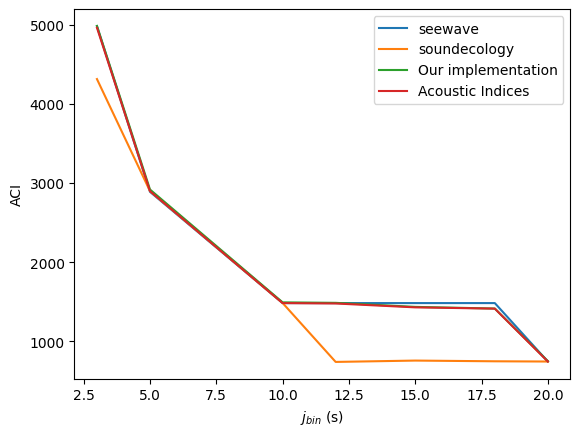

In [65]:
# plot j_bin changes at 2048 FFT window size
name_map = {"SW": "seewave", "SE": "soundecology", "K": "Our implementation", "AI": "Acoustic Indices"}
vals_2048 = full_df[[2048]].drop((2048, "SM"), axis=1)
vals_2048.columns = [name_map[x[1]] for x in vals_2048.columns.to_flat_index()]
vals_2048 = vals_2048.iloc[5:]
plot_2048 = vals_2048.plot(y=vals_2048.columns, xlabel="$j_{bin}$ (s)", ylabel="ACI")
fig = plot_2048.get_figure()
plots.save_plt_fig(fig, "output/ACI_2048", ext="png")
fig

In [80]:
# save csv
full_df.columns = [f"{col[0]}_{col[1]}" for col in full_df.columns.to_flat_index()]
full_df.to_csv("output/aci_values.csv")
full_df.columns[1]

'256_SE'